# Spatial Target Cells

Analyses for if cells care about the spatial target.

TODO: fix up notebook:
- check through 'temp' fixes that are hanging around

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import numpy as np

from convnwb.io import load_nwbfile

from spiketools.spatial.occupancy import (compute_nbins, compute_bin_firing, 
                                          compute_bin_edges, compute_bin_assignment)
from spiketools.spatial.information import compute_spatial_information
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.data import plot_bar
from spiketools.plts.spatial import plot_heatmap, plot_positions
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import color_pval
from spiketools.utils import set_random_seed
from spiketools.utils.data import get_range, restrict_range, get_value_by_time, get_value_by_time_range
from spiketools.utils.trials import epoch_data_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions#, compute_bin_firing
from target import compute_spatial_target_bins, get_trial_target, create_df_target, fit_anova_target

## Settings

In [5]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [6]:
# Define the base data folder
#data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH/NWB')
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/NWB')
#data_folder = Path('/scratch/tom.donoghue/TH/NWB')

In [7]:
# Define subject information
session = {
    'task' : 'THF',
    'subject' : 'wv001',
    'session' : 2    
}

In [8]:
# Define binning for chests (spatial target)
chest_bins = [5, 7]
#chest_bins = [6, 8]
n_bins = compute_nbins(chest_bins)

In [9]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 500

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
    #shuffle_kwargs = {'shuffle_min' : 20000}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {}

In [10]:
# Set example unit to analyze
uind = 36

In [11]:
# Set which analysis method to run
METHOD = 'INFO'  # 'INFO' / 'ANOVA'

## Load Data

In [12]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

#### Get Trial Data

In [13]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [14]:
# Extract behavioural markers of interest
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

#### Get Spiking Data

In [15]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [16]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Get Position Data

In [17]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:] 
positions = nwbfile.acquisition['position']['player_position'].data[:].T

In [18]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

## Chest Positions

In [19]:
# Check chest position range
print('Chest X position range: {:1.2f} - {:1.2f}'.format(np.min(chest_xs), np.max(chest_xs)))
print('Chest Y position range: {:1.2f} - {:1.2f}'.format(np.min(chest_ys), np.max(chest_ys)))

Chest X position range: 362.86 - 406.85
Chest Y position range: 321.34 - 396.47


In [20]:
# Check traversal position range
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[0, :]), np.max(positions[0, :])))
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[1, :]), np.max(positions[1, :])))

Position X range: 365.40 - 404.59
Position X range: 285.00 - 433.00


In [21]:
# Select the position values for navigation periods
_, positions_trials = epoch_data_by_range(ptimes, positions,
                                          nwbfile.trials.navigation_start[:],
                                          nwbfile.trials.navigation_stop[:])

In [22]:
# Compute edges for chest binning
area_range = [[360, 410], [320, 400]]
x_edges, y_edges = compute_bin_edges(positions, chest_bins, area_range=area_range)

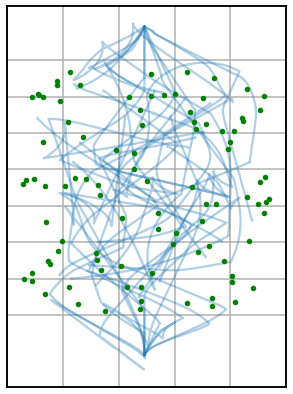

In [23]:
# Plot the subject positions, overlaid with chest positions
landmarks = {'positions' : np.array([chest_xs, chest_ys]), 'color' : 'green'}
plot_positions(positions_trials, landmarks=landmarks, x_bins=x_edges, y_bins=y_edges, figsize=(5, 7))

In [24]:
# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_bin_assignment(chest_pos, x_edges, y_edges)

In [25]:
# Compute chest occupancy
chest_occupancy = compute_bin_firing(chest_bins, ch_xbin, ch_ybin)

In [26]:
# Check the number of chests per bin
print("Range of chests per bin: {:1.0f} - {:1.0f}".format(*get_range(chest_occupancy)))

Range of chests per bin: 0 - 6


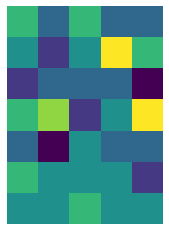

In [27]:
# Plot chest occupancy
plot_heatmap(chest_occupancy)

## Single Trial

In [28]:
# Get trial information
t_ind = 2
t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [29]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [30]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [31]:
# Restrict spikes to the 
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

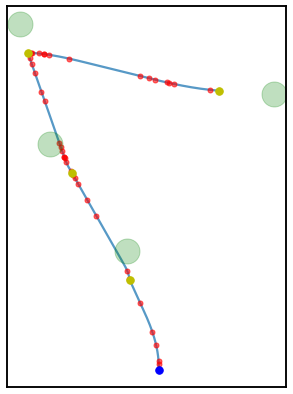

In [32]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
tspikes = {'positions' : np.array([t_spike_xs, t_spike_ys]), 'ms' : 10, 'alpha' : 0.6}
landmarks = [{'positions' : np.array([chest_xs[t_mask], chest_ys[t_mask]]),
              'color' : 'green', 'ms' : 50, 'alpha' : 0.25},
             {'positions' : np.atleast_2d(t_pos[:, 0]).T, 'color' : 'blue', 'ms' : 15},
             {'positions' : np.array(ch_times).T, 'color' : 'y', 'ms' : 15}]
plot_positions(t_pos, tspikes, landmarks, alpha=0.75, figsize=(5, 7))

## Spatial Target Bins

In [33]:
# Collect firing per chest location across all trials
target_bins = compute_spatial_target_bins(spikes, nav_starts, chest_openings, chest_trials, 
                                          ptimes, positions, chest_bins, ch_xbin, ch_ybin)
target_bins = target_bins.T # TEMP FIX

In [34]:
# Check range of firing across spatial target bins
get_range(target_bins)

(0.0, 8.98198735960069)

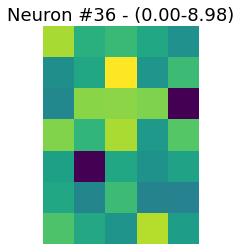

In [35]:
# Check the firing rate per spatial destination for an example neuron
plot_heatmap(target_bins, #transpose=True,
             title='Neuron #{} - ({:1.2f}-{:1.2f})'.format(uind, *get_range(target_bins)))

## Statistical Analyses

In [36]:
# Create shuffles
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

## Spatial Information

In [37]:
# Compute spatial information for the target firing
spike_info = compute_spatial_information(target_bins, chest_occupancy)
print(spike_info)

0.03242177942059695


In [38]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    target_bins = compute_spatial_target_bins(stimes, nav_starts, chest_openings, chest_trials, 
                                              ptimes, positions, chest_bins, ch_xbin, ch_ybin)
    target_bins = target_bins.T # TEMP FIX
    surrs[ind] = compute_spatial_information(target_bins, chest_occupancy)

In [39]:
# Compute surrogate statistics
p_val, z_score = compute_surrogate_stats(spike_info, surrs)

## ANOVA

In [40]:
# Get the target related firing per trial
target_trial = get_trial_target(spikes, nav_starts, chest_bins, chest_openings,
                                chest_trials, ch_xbin, ch_ybin, ptimes, positions)

In [41]:
# TEMP:
target_trial[target_trial == 0] = np.nan

In [42]:
# Create the dataframe
df = create_df_target(target_trial)

In [43]:
# Fit the ANOVA, and get the f-value
f_val = fit_anova_target(df)
f_val

1.4046528554094535

In [44]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    
    data = get_trial_target(shuffle, nav_starts, chest_bins, chest_openings,
                            chest_trials, ch_xbin, ch_ybin, ptimes, positions)
    # TEMP:
    data[data == 0] = np.nan
    df = create_df_target(data)
    surrogates[ind] = fit_anova_target(df)

In [45]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates)

## All Cells

In [48]:
# # Plot spatial target heat maps for all cells
# for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):
    
#     spikes = nwbfile.units.get_unit_spike_times(ii)
    
#     # Compute overall target binning (need for spatial info & plots)
#     target_bins = compute_spatial_target_bins(spikes, nav_starts, chest_openings, chest_trials, 
#                                               ptimes, positions, chest_bins, ch_xbin, ch_ybin)
#     target_bins = target_bins.T # TEMP FIX
    
#     # Compute real data value
#     if METHOD == 'INFO':
#         data_value = compute_spatial_information(target_bins, chest_occupancy)
    
#     if METHOD == 'ANOVA':
#         data = get_trial_target(shuffle, nav_starts, chest_bins, chest_openings,
#                                 chest_trials, ch_xbin, ch_ybin, ptimes, positions)
#         data_value = fit_anova_target(create_df_target(data))
    
#     # Compute measures on surrogates
#     surrogates = np.zeros(n_surrogates)
#     times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
#     for ind, shuffle in enumerate(times_shuffle):
        
#         if METHOD == 'INFO':
#             starget_bins = compute_spatial_target_bins(shuffle, nav_starts, chest_openings, chest_trials, 
#                                                       ptimes, positions, chest_bins, ch_xbin, ch_ybin) 
#             starget_bins = starget_bins.T # TEMP FIX
#             surrogates[ind] = compute_spatial_information(starget_bins, chest_occupancy)
            
#         if METHOD == 'ANOVA':
#             data = get_trial_target(shuffle, nav_starts, chest_bins, chest_openings,
#                                     chest_trials, ch_xbin, ch_ybin, ptimes, positions)
#             surrogates[ind] = fit_anova_target(create_df_target(data))

#     # Compute z-score & p-value based on surrogates
#     p_val, z_score = compute_surrogate_stats(data_value, surrogates, plot=False, verbose=False, ax=ax)

#     # Plot target location heatmap
#     plot_heatmap(target_bins, transpose=True, ax=ax)    
#     ax.set_title('U{} ({:1.2f}-{:1.2f}) \n z-{:1.2f}, p-{:1.2f}'.format(
#                      ii, *get_range(target_bins), z_score, p_val),
#                  fontdict={'fontsize' : 12}, color=color_pval(p_val))